# Rank composites

Optical satellite imagery contains gaps due to clouds, and the observation scenario. Many methods rely on having gap-free data available at regular time intervals. The most common technique to achieve this is to combine pixels from different observations, which is also referred to as compositing.

Various compositing approaches exist, in this notebook, we demonstrate ‘rank composites’ or more specifically the ‘max NDVI’ composite. A rank composite uses a single ‘rank band’ to decide if pixels of other bands are included in the composite. The advantage of rank composites over compositing per band is that the spectral signal represented by the different bands has been observed in reality in a single observation, and is not a combination of spectral values that occurred at different points in time.

This method is used in various peer reviewed publications, and some of its properties have been validated based on specific sensors: https://www.tandfonline.com/doi/abs/10.1080/01431168608948945

In this case the 'rank band' is a simple NDVI, which we 'score' based on the maximum value. The rank band can also be a combination of values leading to a more complex score, such as distance to cloud and observation angles. This variant is called a 'best available pixel' composite. (https://doi.org/10.1080/07038992.2014.945827)

## openEO implementation

To implement this method in openEO are relatively simple, but may be different from the steps in a 'traditional' programming language:

1. We load and compute the rank band separately
2. The rank band is converted into a mask, retaining only pixels that we want to select
3. A datacube with raw bands is loaded, and the rank band mask is applied to it
4. aggregate_temporal(_period) is used to create a composite at regular intervals if needed

Most methods require composites for multiple time periods as input. For instance, one composite per month, or every 10 days. We can compute these in one process graph, using apply_neighborhood, so that the result is also an immediate input for further processing.


In [1]:
spatial_extent = {'west': 4.45, 'east': 4.50, 'south': 51.16, 'north': 51.17, 'crs': 'epsg:4326'}

In [3]:
import openeo
import xarray
import io
import requests

import panel as pn

import pyproj
import matplotlib.pyplot as plt


%matplotlib inline

In [4]:
c=openeo.connect("openeo-dev.vito.be")
c.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo-dev.vito.be/openeo/1.1/' with OidcBearerAuth>

In [5]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = ["2022-06-04", "2022-08-04"],
    bands = ["SCL"],
    max_cloud_cover=85
)

cloud_mask = scl.process(
    "to_scl_dilation_mask",
    data=scl,
    kernel1_size=17, kernel2_size=77,
    mask1_values=[2, 4, 5, 6, 7],
    mask2_values=[3, 8, 9, 10, 11],
    erosion_kernel_size=3)


In [6]:


ndvi_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = ["2022-06-04", "2022-08-04"],
    bands = ["B04", "B08"],
    max_cloud_cover=85
)

ndvi_bands = ndvi_bands.mask(cloud_mask)

ndvi = ndvi_bands.ndvi(nir="B08",red="B04")



In [8]:
def max_ndvi_selection(ndvi):
    max_ndvi = ndvi.max()
    return ndvi.array_apply(lambda x:x==max_ndvi)

rank_mask = ndvi.apply_neighborhood(
        max_ndvi_selection,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

In [ ]:

rank_mask.filter_bbox(spatial_extent).execute_batch("the_mask.nc")

In [4]:
mask_ds = xarray.open_dataset('the_mask.nc')
mask_ds

<xarray.Dataset>
Dimensions:  (t: 12, x: 352, y: 119)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-04 2022-06-11 ... 2022-07-29 2022-08-03
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs      |S1 ...
    var      (t, y, x) uint8 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.15.1a1
    description:  
    title:

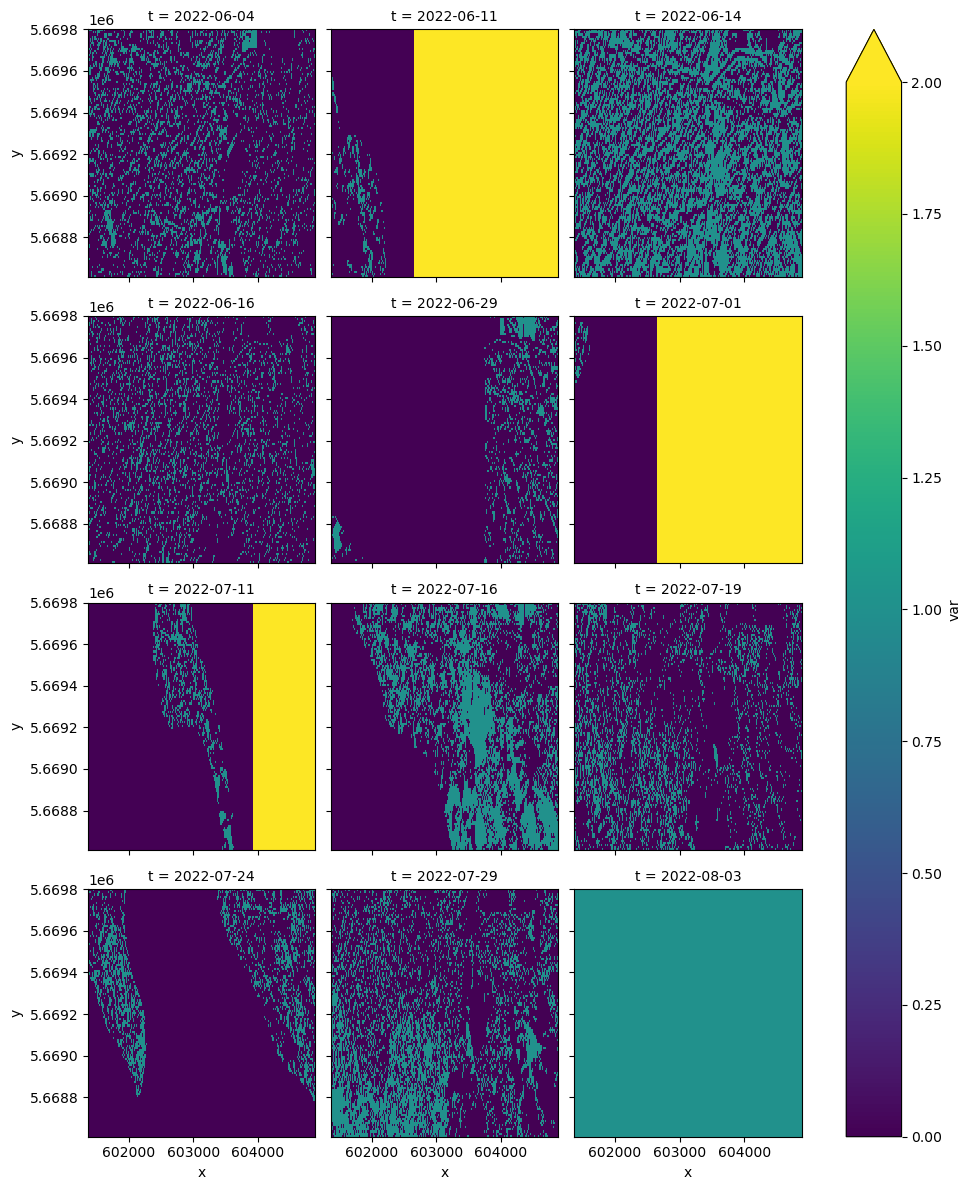

In [5]:
mask_ds['var'].plot(vmin=0,vmax=2,col="t",col_wrap=3)

In [ ]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = ["2022-06-04", "2022-08-04"],
    bands = ["B02", "B03"],
    max_cloud_cover=85
)

composite = rgb_bands.mask(rank_mask).merge_cubes(ndvi_bands.mask(rank_mask)).aggregate_temporal_period("month","first")

composite.filter_bbox(spatial_extent).download("composite.nc")

In [7]:
composite = xarray.open_dataset('composite.nc')
composite

<xarray.Dataset>
Dimensions:  (t: 3, x: 352, y: 119)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-01 2022-07-01 2022-08-01
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs      |S1 ...
    B02      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
    B08      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [8]:
import numpy as np
rgb_array=composite.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000
rgb_array

<xarray.DataArray (bands: 3, t: 3, y: 119, x: 352)>
array([[[[0.1052, 0.1132, 0.0934, ..., 0.0836, 0.0924, 0.1092],
         [0.0951, 0.0937, 0.091 , ..., 0.1268, 0.1338, 0.153 ],
         [0.094 , 0.0934, 0.0944, ..., 0.1248, 0.115 , 0.135 ],
         ...,
         [0.115 , 0.1158, 0.0732, ..., 0.0229, 0.0258, 0.0352],
         [0.0726, 0.0626, 0.0646, ..., 0.0215, 0.0238, 0.031 ],
         [0.0651, 0.0579, 0.0664, ..., 0.0225, 0.023 , 0.0264]],

        [[0.1178, 0.0976, 0.07  , ..., 0.0852, 0.0925, 0.1216],
         [0.1094, 0.1128, 0.0886, ..., 0.1272, 0.136 , 0.1508],
         [0.0886, 0.0954, 0.0982, ..., 0.1144, 0.1144, 0.1334],
         ...,
         [0.1048, 0.0935, 0.0618, ..., 0.0286, 0.0277, 0.0358],
         [0.0608, 0.0618, 0.0632, ..., 0.0288, 0.0288, 0.0334],
         [0.0547, 0.0532, 0.0554, ..., 0.0292, 0.0278, 0.0279]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
...
         [0.0894, 0.1009, 0.0596, ..., 0.0232, 0.026 , 0.0336],
         [0.0581, 0.0454, 0.0493, ..., 0.0221, 0.0253, 0.026 ],
         [0.0488, 0.0427, 0.0553, ..., 0.0222, 0.0241, 0.0218]],

        [[0.1164, 0.0691, 0.0498, ..., 0.0678, 0.0754, 0.0897],
         [0.1196, 0.1186, 0.0736, ..., 0.0996, 0.1022, 0.107 ],
         [0.0714, 0.0825, 0.0855, ..., 0.0928, 0.0794, 0.1272],
         ...,
         [0.0772, 0.071 , 0.0827, ..., 0.0218, 0.0243, 0.0304],
         [0.0476, 0.0453, 0.0844, ..., 0.0247, 0.0248, 0.0274],
         [0.0468, 0.0375, 0.0798, ..., 0.0254, 0.0255, 0.0254]],

        [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         ...,
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan],
         [   nan,    nan,    nan, ...,    nan,    nan,    nan]]]],
      dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-01 2022-07-01 2022-08-01
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
  * bands    (bands) object 'B04' 'B03' 'B02'

/usr/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


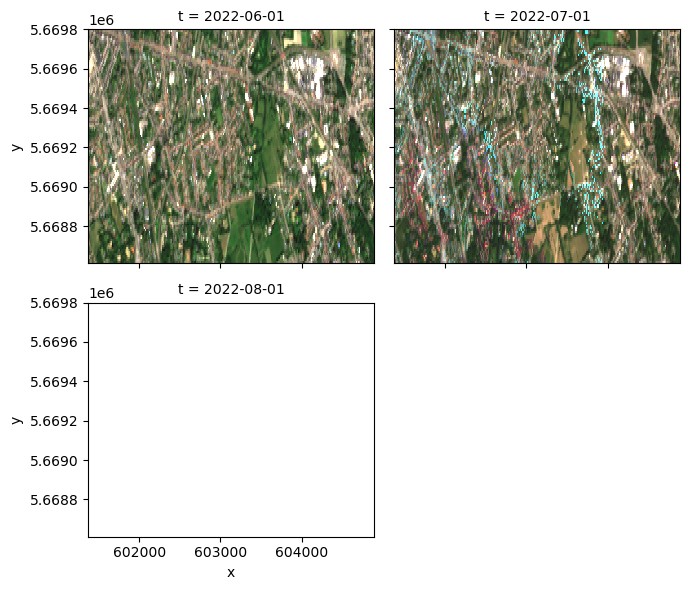

In [9]:
import matplotlib

xarray.plot.imshow(rgb_array,vmin=0,vmax=0.18,col="t",rgb="bands",col_wrap=2)